<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/master/notebooks/dendritic_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Please open this file in Google Colab in order to run this notebook simply and interactively.**

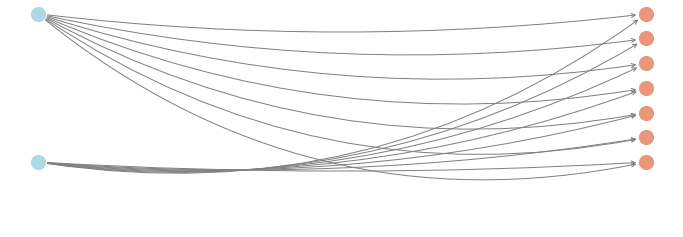

# **Dendritic computation**

---
In this notebook, we will give a very simple example for dendritic computation. 

We will visualize how dendritic computation allows the brain to localize sound, even though the speed of sound travelling between one ear and another is much faster than the spiking cycle of a neuron. We will see how differently delayed synapses between the input and response neurons will allow very specific neurons to spike, depending on the timing between the left and the right input signal (which resemble the location of the sound source).

---



#### Installs & Imports

Fist, we install brian2 and our neuropynamics tools again.

In [1]:
!pip install brian2 -q
!git clone https://github.com/DiGyt/neuropynamics/ -q

     |████████████████████████████████| 1.2MB 8.2MB/s 
     |████████████████████████████████| 5.9MB 14.4MB/s 


Import everything we need.

In [2]:
import numpy as np
import networkx as nx
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from brian2 import (second, ms, us, volt, mV, cm, umetre, ufarad, siemens, msiemens, mA)
from brian2 import (start_scope, NeuronGroup, Synapses, SpikeGeneratorGroup,
                    StateMonitor, SpikeMonitor, run, defaultclock)

from neuropynamics.src.utils.plotting import (plot_cmesh, plot_signals,
                                              plot_spikes, plot_synapses)

## Step-by-step

First of all, we define a Hodgkin-Huxley neuron model (Hodgkin & Huxley, 1990), which will serve as the model of our response neurons. We will use a standard representation with all parameters set to standard values. Then we adapt the spiking threshold (i.e. the voltage at which our brian2 simulation should register spikes), at a reasonable value ($v > 47.8 mV$). This allows us to later distinguish which neuron had the highest activation.

In [3]:
# define the model
model = '''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    '''   
# Define threshold and refractory period
threshold = 'v > 47.8*mV'
refractory = 'v > -40*mV'

# Define static parameters of our model
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area # Mebrane capacitance
gl = 5e-5*siemens*cm**-2 * area
El = -65.*mV
EK = -90.*mV
ENa = 50.*mV
g_na = 100.*msiemens*cm**-2 * area
g_kd = 30.*msiemens*cm**-2 * area
VT = -63*mV

Now we will build a network setup with this model and start a simulation.

Our setup will consist of N (=7) response Hodgkin-Huxley Neurons, that are innervated by two input spikes, one representing an auditory stimulus coming from the left and one auditory stimulus from the right. These stimuli will come in at slightly different times, resembling the time that a certain sound source reaches the left ear and the right ear. The temporal delay that sound needs to travel between the ears of an average human skull is usually not larger than 1 ms (more like 0.6 ms).

As the computation happens in the dendritic part of our model, we also have to arange the synapses of our setup in a special way. Our left input neuron will innervate the first response neuron with a temporal delay of 0.1 ms, the second with 0.2 ms, then 0.3 ms and so on. For the right input neuron, it will be the other way round, such that it innervates the *last* response neuron by 0.1 ms and then increases temporal delay for the following neurons. We will visualize this setup after the simulation.

After creating the neurons and synapses of our model, we will simply run it for a few miliseconds, and record the spikes and membrane potential.

In [4]:
# start a brian2 scope with increased temporal resolution
defaultclock.dt = 0.05*ms
start_scope()

# define the spiking times of our left/right input as well as the neuron number
left_pulse = 2.0 * ms
right_pulse = 2.3 * ms
N = 7

# Create the left/right stimulus neurons as SpikeGenerators
inputs = SpikeGeneratorGroup(2, indices=[0, 1], times=[left_pulse, right_pulse])

# Create a group of Hodgkin-Huxley neurons, using the above model
neurons = NeuronGroup(N, model=model,
                      threshold=threshold,
                      refractory=refractory,
                      method='exponential_euler')

# create the left group of synapses from Neuron 0 (left) to the response group
synapses_0 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
synapses_0.connect(i=0, j=np.arange(N))
synapses_0.weight = 40 * mV
synapses_0.delay = np.arange(1, N+1)/10 * ms

# create the right group of synapses from Neuron 1 (right) to the response group
synapses_1 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
synapses_1.connect(i=1, j=np.arange(N))
synapses_1.weight = 40 * mV
synapses_1.delay =  np.arange(N+1, 1, -1)/10 * ms

# we will run 2 ms without recording to give the neurons time to normalize their potential
run(2*ms)

# run the simulation while monitoring it
states = StateMonitor(neurons, 'v', record=True)
spikes = SpikeMonitor(neurons, 'v', record=True)
inp_spikes = SpikeMonitor(inputs, record=True)
run(3*ms)

First, we should inspect how the network that we've just build looks like. Using a bipartite graph layout, we can clearly distinguish our setup with the left and right auditory input neurons displayed on the left side, and the response neurons on the right side. The length of the network connections (or actually the degree in which they are bent) represents the temporal delay between one input and one response neuron.

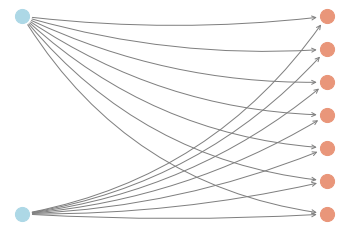

In [5]:
plot_synapses(neuron_groups=[inputs, neurons],
              synapse_groups=[synapses_0, synapses_1],
              pos_func=lambda x:nx.bipartite_layout(x, nodes=[0,1]), 
              color_cycle=["lightblue", "darksalmon"],
              bend_factor=30.)

If we plot the spiking responses, you should see different neurons spiking, dependent on whether the left input preceded the right input or vice versa. Sometimes, brian2 might register no spikes at all, which is mostly due to the fact that we only used standard parameters for all of our neuron models and didn't bother to tune their spiking thresholds and other variables accordingly. In that case, you can use the membrane potential plot below to investigate the spikes.

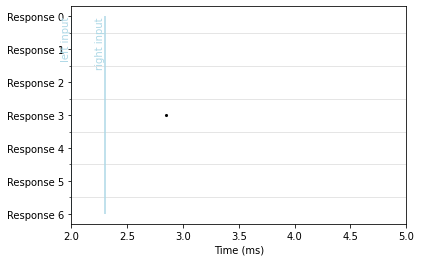

In [6]:
# assign channel names to our response neurons
ch_names = ["Response " + str(i) for i in range(len(neurons))]

# plot the spikes
plot_spikes(spikes.i, spikes.t/ms, neurons, ch_names,time_unit="ms", show=False)
plt.xlim(2, 5)

# add lines to indicate the left/right input timing
plt.vlines(x=[left_pulse/ms, right_pulse/ms], ymin=0, ymax=len(neurons)-1, color = 'lightblue')
for name, time in zip(["left input", "right input"], [left_pulse, right_pulse]):
  plt.text(time/ms, len(neurons)-1, name, rotation=90, c="lightblue",
          verticalalignment="top", horizontalalignment="right")

Looking at the membrane potentials, you can see more clearly how dendritic computation works. The signals sent to our response neurons (distinguishable by the diagonal activation bursts) will sum up in different neurons, depending on whether the left or right stimulus comes first as well as the temporal delay between them. This mostly leads to very high membrane potentials in quite specific neurons, which then indicate an auditory stimulus coming from a certain degree.

From this plot, you can also see that this process of computation works at timesteps that are way shorter than the activation cycle of a single neuron (which last approximately 1 ms in this model).

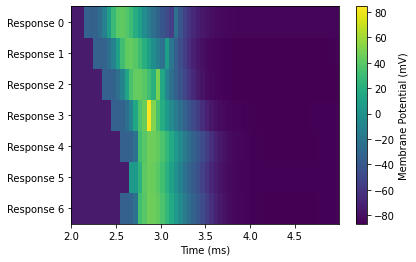

In [7]:
plot_cmesh(states.v/mV, states.t/ms, ch_names, time_unit="ms", unit="Membrane Potential (mV)")

## Try it out yourself

Here we will put all of the code above into one interactive function, so you can play around with the timing of the left and right input.

In [9]:
def dendritic_computation(left, right, N):

  # define the model
  model = '''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    '''   
  # Define threshold and refractory period
  threshold = 'v > 47.8*mV'
  refractory = 'v > -40*mV'

  # fixed parameters
  area = 20000*umetre**2
  Cm = 1*ufarad*cm**-2 * area # Mebrane capacitance
  gl = 5e-5*siemens*cm**-2 * area
  El = -65.*mV
  EK = -90.*mV
  ENa = 50.*mV
  g_na = 100.*msiemens*cm**-2 * area
  g_kd = 30.*msiemens*cm**-2 * area
  VT = -63*mV

  # simulation timing
  defaultclock.dt = 0.05*ms

  start_scope()

  left_pulse = left * ms
  right_pulse = right * ms

  # define the left/right stimulus neurons
  inputs = SpikeGeneratorGroup(2, indices=[0, 1], times=[left_pulse, right_pulse])

  # Create a group of Izhikevich neurons
  neurons = NeuronGroup(N, model=model,
                        threshold=threshold,
                        refractory=refractory,
                        method='exponential_euler')

  # create the left group of synapses from Neuron 0 to the last five
  synapses_0 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
  synapses_0.connect(i=0, j=np.arange(N))
  synapses_0.weight = 40 * mV
  synapses_0.delay =  np.arange(1, N+1)/10 * ms

  # create the right group of synapses from Neuron 0 to the last five
  synapses_1 = Synapses(inputs, neurons, 'weight : volt', on_pre='v_post += weight')
  synapses_1.connect(i=1, j=np.arange(N))
  synapses_1.weight = 40 * mV
  synapses_1.delay =  np.arange(N+1, 1, -1)/10 * ms

  # run the simulation while monitoring it
  states = StateMonitor(neurons, 'v', record=True)
  spikes = SpikeMonitor(neurons, 'v', record=True)
  inp_spikes = SpikeMonitor(inputs, record=True)
  run(5*ms)

  # plot the network
  plt.figure(figsize=[15,5])
  plt.subplot(1, 3, 1)
  plt.title("Network Layout")
  plot_synapses(neuron_groups=[inputs, neurons],
                synapse_groups=[synapses_0, synapses_1],
                pos_func=lambda x:nx.bipartite_layout(x, nodes=[0,1]), 
                color_cycle=["lightblue", "darksalmon"], show=False,
                bend_factor=10.)

  # plot the spiking times
  plt.subplot(1, 3, 2)
  plt.title("Spiking Times")
  ch_names = ["Resp. " + str(i) for i in range(len(neurons))]
  plot_spikes(spikes.i, spikes.t/ms, neurons, ch_names,time_unit="ms", show=False)
  plt.xlim(2, 5)
  plt.vlines(x=[left_pulse/ms, right_pulse/ms], ymin=0, ymax=len(neurons)-1, color = 'lightblue')
  for name, time in zip(["left input", "right input"], [left_pulse, right_pulse]):
    plt.text(time/ms, len(neurons)-1, name, rotation=90, c="lightblue",
            verticalalignment="top", horizontalalignment="right")

  # plot the membrane potential
  plt.subplot(1, 3, 3)
  plt.title("Membrane Potential")
  plot_cmesh(states.v[:, states.t >= 2*ms]/mV, states.t[states.t >= 2*ms]/ms, ch_names, time_unit="ms", unit="Membrane Potential (mV)", show=False)


layout = {'width': '500px'}; style = {'description_width': '200px'}
left_slider = FloatSlider(value = 2., min= 2., max = 4., step = 0.01, description = 'Left input spike (ms):', continuous_update=False, layout=layout, style=style)
right_slider = FloatSlider(value = 2., min= 2., max = 4., step = 0.01, description = 'Right input spike (ms):', continuous_update=False, layout=layout, style=style)
N_slider = IntSlider(value = 10, min= 2, max = 20, step = 1, description = 'Number of response neurons:', continuous_update=False, layout=layout, style=style)

interactive(dendritic_computation, left=left_slider, right=right_slider, N=N_slider)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='Left input spike (ms):', la…

##References

Hodgkin, A. L., & Huxley, A. F. (1990). A quantitative description of membrane current and its application to conduction and excitation in nerve. Bulletin of mathematical biology, 52(1-2), 25-71.